# Haar Feature Visualization

Demonstrate the 5 types of Haar-like features and their responses on sample face patches.

**Feature Types**:
- 2h: Two horizontal rectangles
- 2v: Two vertical rectangles
- 3h: Three horizontal rectangles
- 3v: Three vertical rectangles
- 4d: Four diagonal rectangles

**AI Usage**: Notebook structure assisted by Claude Code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys
from pathlib import Path

sys.path.insert(0, str(Path.cwd().parent / 'src'))

from features.integral_image import compute_ii_fast
from features.haar_features import HaarFeature, visualize_feature, generate_haar_features

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 1. Visualize Feature Types

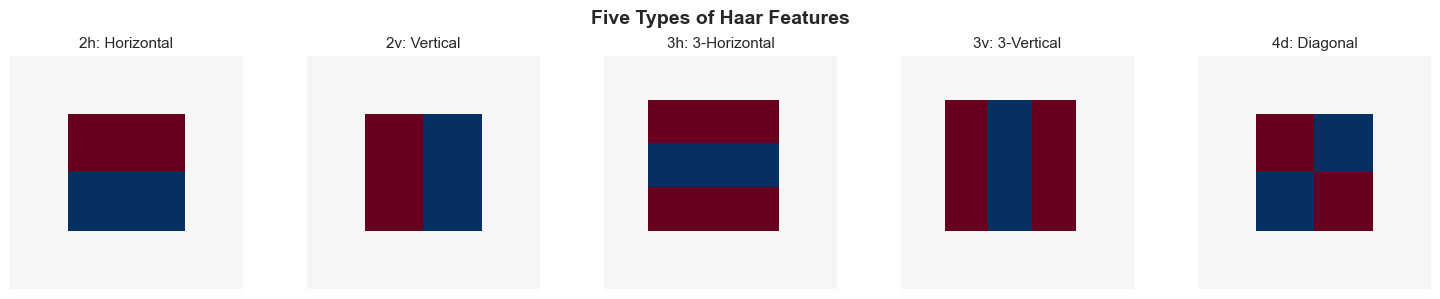

White regions: positive contribution
Red regions: negative contribution
Feature value = sum(white) - sum(red)


In [2]:
# Example features of each type
example_features = [
    HaarFeature('2h', 4, 4, 8, 8),   # Horizontal edge detector
    HaarFeature('2v', 4, 4, 8, 8),   # Vertical edge detector
    HaarFeature('3h', 3, 3, 9, 9),   # Horizontal line detector
    HaarFeature('3v', 3, 3, 9, 9),   # Vertical line detector
    HaarFeature('4d', 4, 4, 8, 8)    # Diagonal pattern detector
]

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
fig.suptitle('Five Types of Haar Features', fontsize=14, fontweight='bold')

titles = ['2h: Horizontal', '2v: Vertical', '3h: 3-Horizontal', '3v: 3-Vertical', '4d: Diagonal']

for ax, feature, title in zip(axes, example_features, titles):
    img = visualize_feature(feature, window_size=16)
    ax.imshow(img, cmap='RdBu_r', vmin=-1, vmax=1)
    ax.set_title(title, fontsize=11)
    ax.axis('off')

plt.tight_layout()
plt.savefig('../results/figures/haar_feature_types.png', dpi=150, bbox_inches='tight')
plt.show()

print('White regions: positive contribution')
print('Red regions: negative contribution')
print('Feature value = sum(white) - sum(red)')

## 2. Load Sample Faces

Loaded 799 face patches


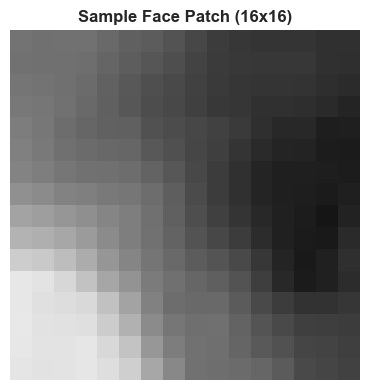

In [3]:
# Load face patches
with open('../data/processed/train_faces.pkl', 'rb') as f:
    faces = pickle.load(f)

print(f'Loaded {len(faces)} face patches')

# Select a sample face
sample_face = faces[42]  # Arbitrary choice

plt.figure(figsize=(4, 4))
plt.imshow(sample_face, cmap='gray', vmin=0, vmax=255)
plt.title('Sample Face Patch (16x16)', fontsize=12, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

## 3. Compute Feature Responses

Show how each feature type responds to the face patch

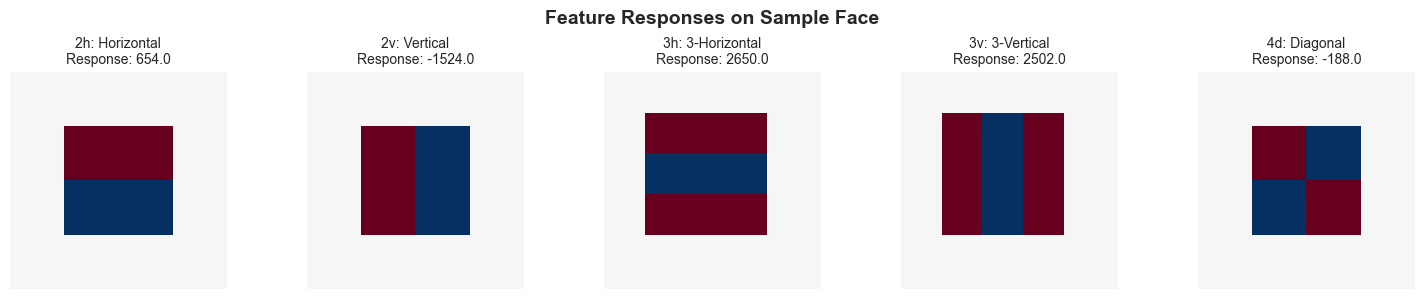

In [4]:
# Compute integral image
ii = compute_ii_fast(sample_face.astype(np.float64))

# Compute responses for example features
responses = [feat.compute(ii) for feat in example_features]

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
fig.suptitle('Feature Responses on Sample Face', fontsize=14, fontweight='bold')

for ax, feature, response, title in zip(axes, example_features, responses, titles):
    img = visualize_feature(feature, window_size=16)
    ax.imshow(img, cmap='RdBu_r', vmin=-1, vmax=1)
    ax.set_title(f'{title}\nResponse: {response:.1f}', fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.savefig('../results/figures/haar_responses_example.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Feature Generation Statistics

Generating Haar features...
Generating Haar features for 16×16 window...
  Generating 2-rectangle horizontal features...
  Generating 2-rectangle vertical features...

Total features: 10,000

Breakdown by type:
  2h: 8,704 ( 87.0%)
  2v: 1,296 ( 13.0%)


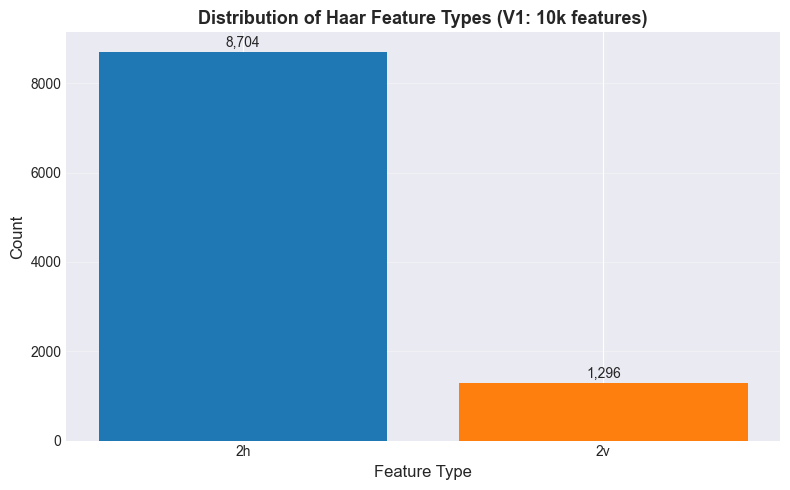

In [5]:
# Generate all features (up to 10k for V1)
print('Generating Haar features...')
features = generate_haar_features(window_size=16, max_features=10000)

# Count by type
type_counts = {}
for feat in features:
    type_counts[feat.type] = type_counts.get(feat.type, 0) + 1

print(f'\nTotal features: {len(features):,}')

print('\nBreakdown by type:')
for ftype, count in sorted(type_counts.items()):
    pct = count / len(features) * 100
    print(f'  {ftype}: {count:5,} ({pct:5.1f}%)')

# Visualize distribution
fig, ax = plt.subplots(figsize=(8, 5))
types = list(type_counts.keys())
counts = list(type_counts.values())

ax.bar(types, counts, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
ax.set_xlabel('Feature Type', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distribution of Haar Feature Types (V1: 10k features)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add count labels
for i, (t, c) in enumerate(zip(types, counts)):
    ax.text(i, c + 100, f'{c:,}', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('../results/figures/haar_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Feature Scale Variations

Show same feature type at different scales

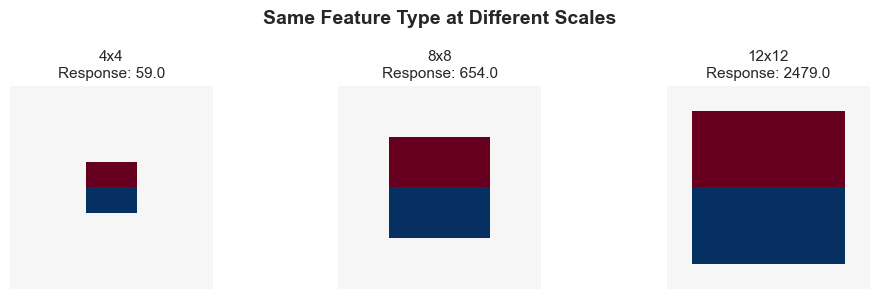

In [6]:
# Create 2h features at different scales
scales = [
    HaarFeature('2h', 6, 6, 4, 4),   # Small
    HaarFeature('2h', 4, 4, 8, 8),   # Medium
    HaarFeature('2h', 2, 2, 12, 12)  # Large
]

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
fig.suptitle('Same Feature Type at Different Scales', fontsize=14, fontweight='bold')

for ax, feat, size in zip(axes, scales, ['4x4', '8x8', '12x12']):
    img = visualize_feature(feat, window_size=16)
    response = feat.compute(ii)
    ax.imshow(img, cmap='RdBu_r', vmin=-1, vmax=1)
    ax.set_title(f'{size}\nResponse: {response:.1f}', fontsize=11)
    ax.axis('off')

plt.tight_layout()
plt.savefig('../results/figures/haar_scales.png', dpi=150, bbox_inches='tight')
plt.show()

## Summary

- **5 feature types** capture edges, lines, and diagonal patterns
- **Multiple scales** detect features at different sizes
- **~10k features** for V1 (can scale to 50k+ for V2)
- **O(1) evaluation** via integral image (any scale, same cost)

These simple features are surprisingly effective when combined with AdaBoost!